In [11]:
import numpy as np
from random import random, uniform, randint
from matplotlib import pyplot as plt
import pandas as pd


from calc import distance, intersection, parallel, angle, orthogonal
from draw import draw
from line import Line
from plane import Plane
from point import Point
from solver import solve
from vector import Vector

__all__ = (
    "Line",
    "Plane",
    "Point",
    "Vector",
    "angle",
    "distance",
    "draw",
    "intersection",
    "orthogonal",
    "parallel",
    "solve",
)

In [12]:
def get_angles(points):
    # вычисление углов полигона
    cnt = points
    num_points = len(cnt)
    angles = []
    for i, point in enumerate(cnt):
        point1 = cnt[i - 1]
        point2 = cnt[i]
        point3 = cnt[(i + 1) % num_points]
        angles.append(int(Vector(point2, point1).angle(Vector(point2, point3))* 180 / np.pi))

    return np.array(angles)

def S_from_triangle(triangle):
    # по точкам треугольника получить площадь
    x1 = triangle[0][0]
    y1 = triangle[0][1]
    x2 = triangle[1][0]
    y2 = triangle[1][1]    
    x3 = triangle[2][0]
    y3 = triangle[2][1]
    return 0.5*abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))

right_triangle = [Point(0, 0, 0), Point(1, 0, 0), Point(0.5, 3**0.5/2, 0)]

def is_point_in_triangle(point, polygon=right_triangle):
    #проверка находится ли точка внутри треугольника
    #проверяем равенство площадей
    S = S_from_triangle(polygon)
    pA = polygon[0]
    pB = polygon[1]
    pC = polygon[2]
    S1 = S_from_triangle([pA, pB, point])
    S2 = S_from_triangle([pA, pC, point])
    S3 = S_from_triangle([pC, pB, point])
    if abs(S-S1-S2-S3) < 0.0001:
        return True
    else:
        return False
    
def from_rk_to_abwt(r, k):
    b = 1/(2*r+1)
    a = r*b
    w = 3**0.5/2*(1-a)
    t = k*w
    return a, b, w, t

In [13]:
def make_random_plane_3_into_sphere_arcsin(r=1.8, center=Point(0.5, 0.5, 0.5)):
    #генерируем плоскость по вектору нормали и свигу вдоль этой нормали
    # r - радиус сдвига (шара который замощают)
    # center - координаты центра
    fi = 2*np.pi*uniform(0, 1)
    teta = np.arccos(2*uniform(0, 1) - 1)
    n = Vector(r*np.sin(teta)*np.cos(fi), 
               r*np.sin(teta)*np.sin(fi),
               r*np.cos(teta))
    alpha = uniform(-1, 1)
    point = Point(alpha*n[0]+center[0], alpha*n[1]+center[1], alpha*n[2]+center[2])
    return Plane(point, n)

def generate_random_plane_angles_wcco_into_sphere_arcsin(wcco, r, k):
    # генерируется плоскость внутри куба и проверяется пересекает ли она данную модель WCCo, возврается список углов
    a, b, w, t = from_rk_to_abwt(r, k)
    plane = make_random_plane_3_into_sphere_arcsin(r=1.8*max(1, t))
    points_intersection = wcco.intersection_with_plane(plane)
    if len(points_intersection) != 0:
        return get_angles(points_intersection)
    else:
        return []
    
def generates_n_plates_wcco(wcco, r, k, n=1000):
    # генерируем n плоскостей и получем распределение углов
    angles = [0]*181
    for i in range(n):
        angs = generate_random_plane_angles_wcco_into_sphere_arcsin(wcco, r, k)
        if len(angs) != 0:
            for ang in angs:
                angles[ang] += 1
    
    return list(np.array(angles)/np.sum(angles))

In [14]:
class WCCoPrism():
    #Модель зерна карбида вольфрама, 
    def __init__(self, r, k):
        
        self.a, self.b, self.w, self.t = from_rk_to_abwt(r, k)
        
        
        self.A = Point(self.a, 0, 0)
        self.B = Point(self.a+self.b, 0, 0)
        self.C = Point(1.5*self.a+self.b, 3**0.5/2*self.a, 0)
        self.D = Point(0.5+self.a/2, self.w, 0)
        self.E = Point(0.5-self.a/2, self.w, 0)
        self.F = Point(0.5*self.a, 3**0.5/2*self.a, 0)
        
        self.G = Point(self.a, 0, self.t)
        self.H = Point(self.a+self.b, 0, self.t)
        self.I = Point(1.5*self.a+self.b, 3**0.5/2*self.a, self.t)
        self.J = Point(0.5+self.a/2, self.w, self.t)
        self.K = Point(0.5-self.a/2, self.w, self.t)
        self.L = Point(0.5*self.a, 3**0.5/2*self.a, self.t)
        
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F,
                               self.G, self.H, self.I, self.J, self.K, self.L]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.CD = Line(self.C, self.D)
        self.DE = Line(self.D, self.E)
        self.EF = Line(self.E, self.F)
        self.FA = Line(self.F, self.A)
        
        self.AG = Line(self.A, self.G)
        self.BH = Line(self.B, self.H)
        self.CI = Line(self.C, self.I) 
        self.DJ = Line(self.D, self.J)
        self.EK = Line(self.E, self.K)
        self.FL = Line(self.F, self.L) 
        
        self.GH = Line(self.G, self.H)
        self.HI = Line(self.H, self.I)
        self.IJ = Line(self.I, self.J)
        self.JK = Line(self.J, self.K)
        self.KL = Line(self.K, self.L)
        self.LG = Line(self.L, self.G)
        
        self.ABC = Plane(self.A, self.B, self.C)
        self.GHI = Plane(self.G, self.H, self.I)
        
        self.ABH = Plane(self.A, self.B, self.H)
        self.BCH = Plane(self.B, self.C, self.H)
        self.CDJ = Plane(self.C, self.D, self.J)
        self.DEK = Plane(self.D, self.E, self.K)
        self.EFL = Plane(self.E, self.F, self.L)
        self.FAG = Plane(self.F, self.A, self.G)
        

        
        self.iterable_edges = [self.AB, self.BC, self.CD, self.DE, self.EF, self.FA,
                               self.AG, self.BH, self.CI, self.DJ, self.EK, self.FL, 
                               self.GH, self.HI, self.IJ, self.JK, self.KL, self.LG]
        
        self.iterable_facets = [self.ABC, self.GHI, self.ABH, self.BCH, 
                                self.CDJ, self.DEK, self.EFL, self.FAG]
        
    def is_point_in_truncated_triangle(self, point):
        polygon = [self.A, self.B, self.C, self.D, self.E, self.F, self.G]
        #проверяем равенство площадей
        S = 3**0.5/4-3*3**0.5/4*self.a**2
        pA = polygon[0]
        pB = polygon[1]
        pC = polygon[2]
        pD = polygon[3]
        pE = polygon[4]
        pF = polygon[5]
        S1 = S_from_triangle([pA, pB, point])
        S2 = S_from_triangle([pB, pC, point])
        S3 = S_from_triangle([pC, pD, point])
        S4 = S_from_triangle([pD, pE, point])
        S5 = S_from_triangle([pE, pF, point])
        S6 = S_from_triangle([pF, pA, point])
        if abs(S-S1-S2-S3-S4-S5-S6) < 0.000001:
            return True
        else:
            return False
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            #right_triangle = [self.A, self.B, self.C]
            # intersect is actually (num, point)
            return (
                self.is_point_in_truncated_triangle(point=point)
                and 0 <= point.z <= self.t
            )
        
        intersections = list(filter(in_bounds, intersections))
        #print('problem not here')
        
        if intersections:
            #print(intersections)
            point = intersections[0]
            polygon = []
            polygon.append(point)
            del intersections[0]
            
            uu_kostyl = 0 

            while intersections:
                for i, p in enumerate(intersections):
                    uu_kostyl += 1
                    flag = False
                    for plane in self.iterable_facets:
                        if (p in plane) and (point in plane):
                            polygon.append(p)
                            del intersections[i]
                            point = p
                            flag = True
                            break
                    if flag:
                        break
                if uu_kostyl > 1000:
                    print('i had a problem with precision')
                    return []
            #print(polygon)
            return polygon
        else:
            #print('[]')
            return []

In [18]:
%%time
arr = generates_n_plates_wcco(wcco=WCCoPrism(r=0.6, k=0.9), r=0.6, k=0.9, n=1000000)

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i got a problem with arccos Vector(0.0, 0.0, 0.0) Vector(0.0, 0.0, 0.0)
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precisio

i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a problem with precision
i had a 

In [22]:
np.savetxt("carbid-model-distr-0-180.txt", np.array(arr))

In [78]:
arr = np.loadtxt("carbid-model-distr-0-180.txt")

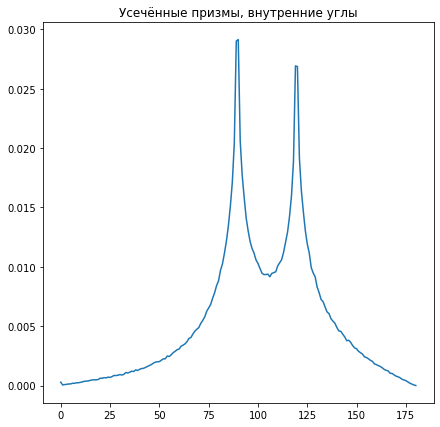

In [79]:
plt.figure(figsize=(7,7))
plt.plot(arr)
plt.title("Усечённые призмы, внутренние углы")
plt.show()

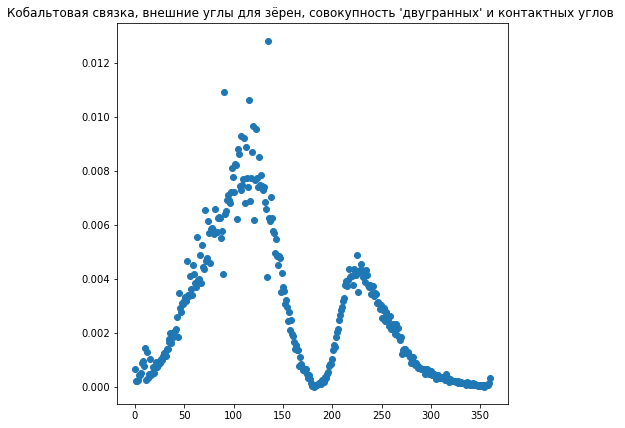

In [80]:
distr_angles_real = np.load("angles_scatter_xy_step_1.npy", allow_pickle=True)
gauss_approx = np.load("angles_gauss_xy_step_1.npy", allow_pickle=True)
plt.figure(figsize=(7,7))
plt.scatter(distr_angles_real[3][0], distr_angles_real[3][1])
plt.title("Кобальтовая связка, внешние углы для зёрен, совокупность 'двугранных' и контактных углов ")
plt.show()

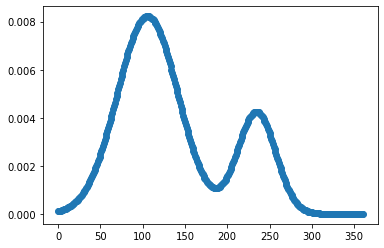

In [26]:
plt.scatter(gauss_approx[3][0], gauss_approx[3][1])

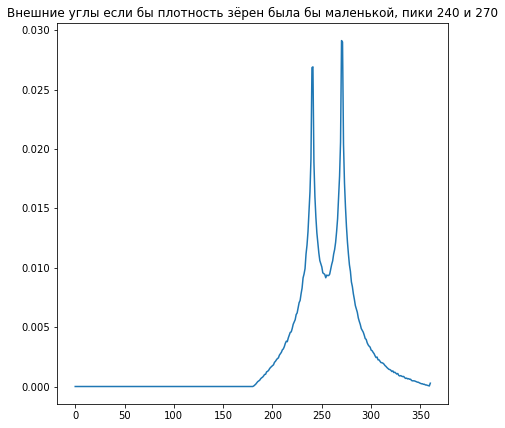

In [18]:
plt.figure(figsize=(7,7))
reverse_arr = [0]*180+list(np.flip(arr))
plt.plot(reverse_arr)
plt.title("Внешние углы если бы плотность зёрен была бы маленькой, пики 240 и 270")
plt.show()

In [19]:
norm_koef = distr_angles_real[3][1][239]
norm_koef

0.003732672625987822

In [20]:
real_prob = np.array(reverse_arr).max()
real_prob

0.029147642839971524

In [21]:
alpha = norm_koef/real_prob
alpha

0.12806087430401178

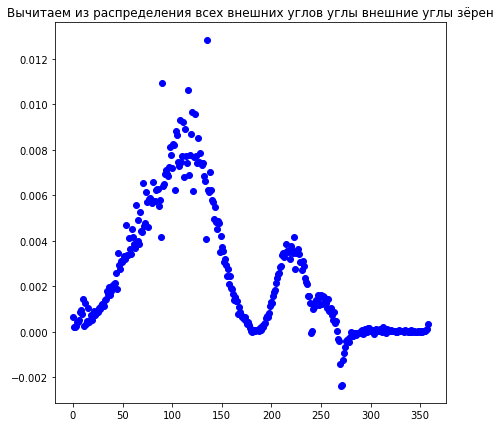

In [22]:
plt.figure(figsize=(7,7))
plt.plot(distr_angles_real[3][1]-alpha*np.array(reverse_arr)[:-2], 'bo')
plt.title("Вычитаем из распределения всех внешних углов углы внешние углы зёрен")
plt.show()

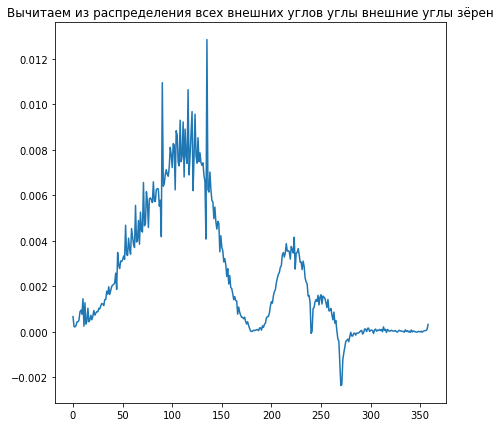

In [23]:
plt.figure(figsize=(7,7))
plt.plot(distr_angles_real[3][1]-alpha*np.array(reverse_arr)[:-2])
plt.title("Вычитаем из распределения всех внешних углов углы внешние углы зёрен")
plt.show()

## Попробуем загрубить теоретическое распределение с точностью до 5 градусов

In [84]:
arr = arr[:-1]
def make_rough_array(arr, degree=5):
    #господи какой тут ужас написан, функция для загрубления теоретически полученного распределения 
    arr = np.array(arr)
    #найдем целое и остаток от деления нацело
    ch = len(arr) // degree
    rem = len(arr) % degree
    #с целой часть поступаем как обычно
    arr_ch = arr[:len(arr)-rem]
    arr_ch = arr_ch.reshape(-1, degree).mean(axis=1)
    
    arr_ch_ = np.zeros_like(arr[:len(arr)-rem].reshape(-1, degree))
    for i in range(degree):
        arr_ch_[:, i] = arr_ch
    
    arr_itor = arr_ch_.reshape(len(arr)-rem)
    
    if rem!=0:
        m_last = arr[len(arr)-rem:].mean()

        arr_itor = np.array(list(arr_itor) + [m_last]*rem)
    return arr_itor

In [101]:
norm_koef = distr_angles_real[3][1][239]

def get_deffirence(degree=5, arr=arr):
    arr_ = make_rough_array(arr, degree)
    reverse_arr_ = [0]*180+list(np.flip(arr_))
    
    plt.figure(figsize=(7,7))
    plt.plot(reverse_arr_)
    plt.title("Внешние углы если бы плотность была маленькой, округление до " + str(degree) + " градусов")
    plt.show()
    
    real_prob_ = np.array(reverse_arr_).max()
    alpha_ = norm_koef/real_prob_
    
    plt.figure(figsize=(7,7))
    plt.plot(distr_angles_real[3][1]-alpha_*np.array(reverse_arr_)[:-1])
    plt.title("Вычитаем из распределения всех внешних углов углы внешние углы зёрен, округление до " + str(degree) + " градусов")
    plt.show()
    

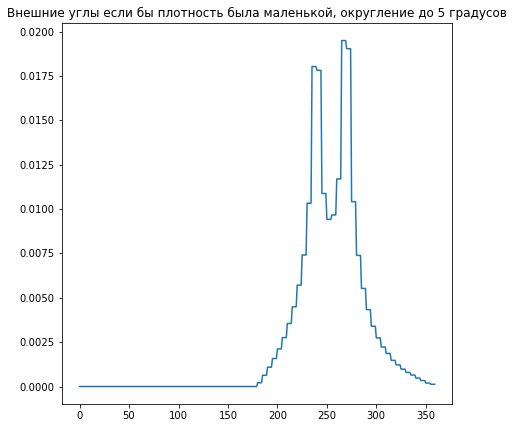

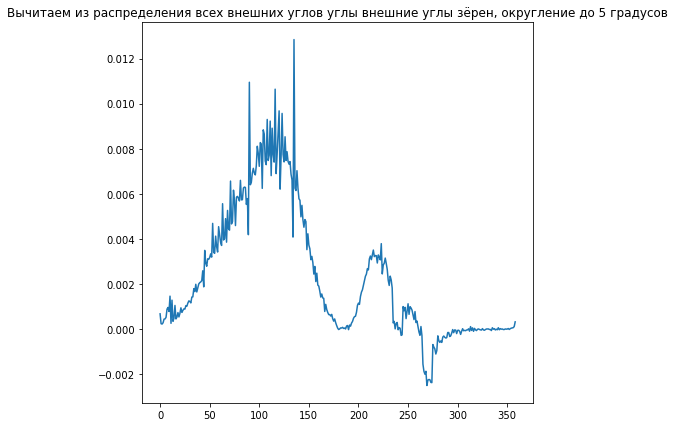

In [102]:
get_deffirence(5, arr)

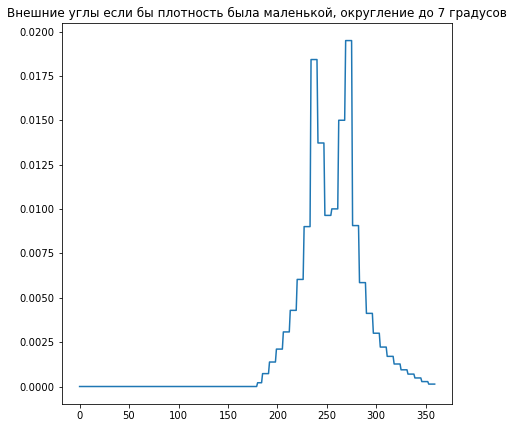

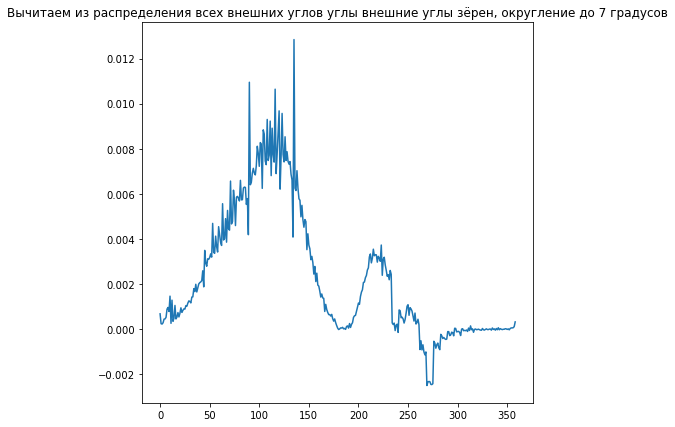

In [103]:
get_deffirence(7, arr)

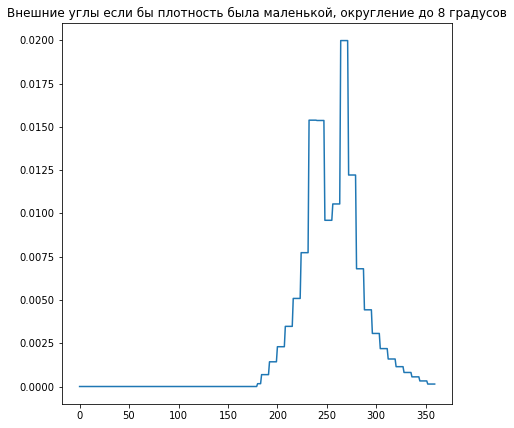

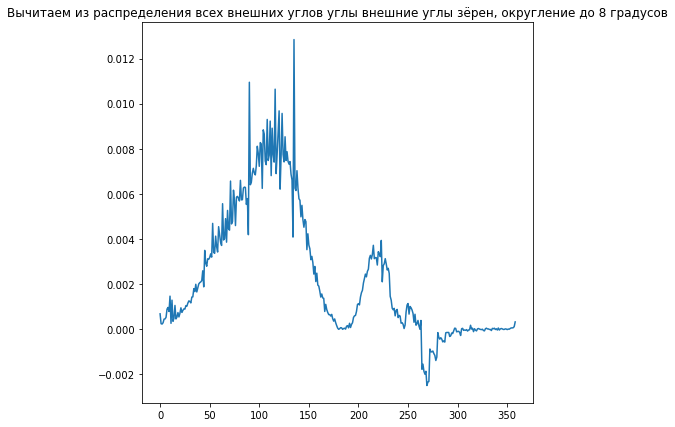

In [104]:
get_deffirence(8, arr)

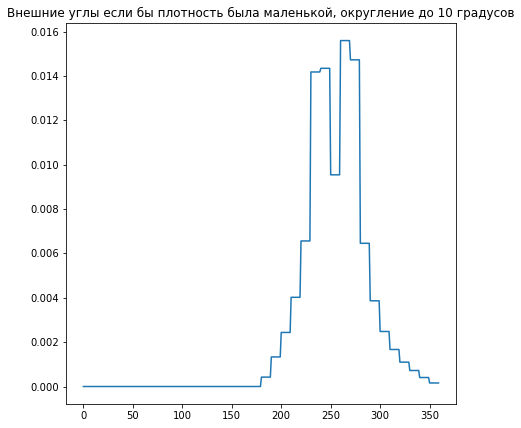

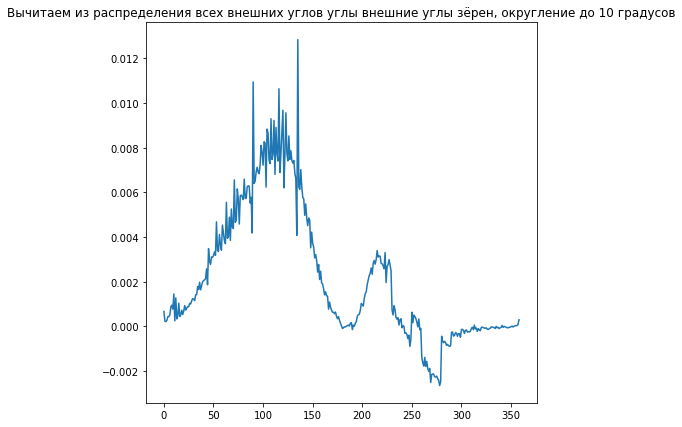

In [105]:
get_deffirence(10, arr)

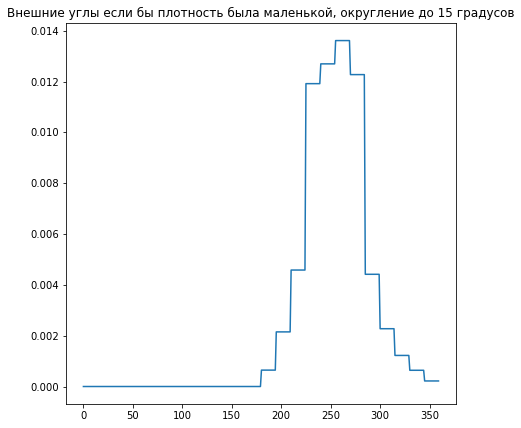

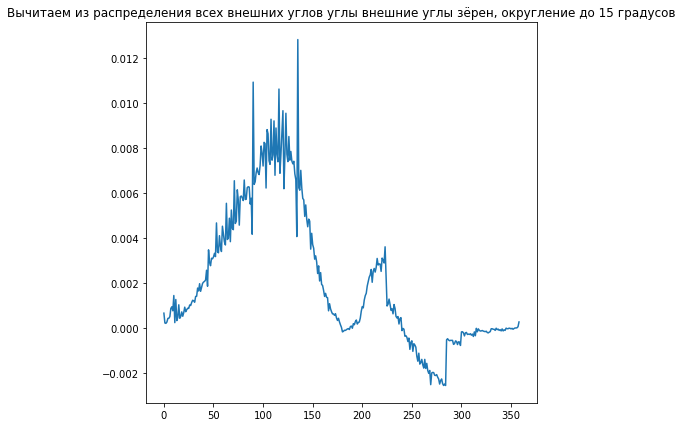

In [106]:
get_deffirence(15, arr)